In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

## Ссылки:
* [Chris Olah's blog (LSTM/GRU)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [PyTorch tutorial - RNN for name classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
* [MNIST classification with RNN tutorial](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
* [Good tutorials about Torch sentiment](https://github.com/bentrevett/pytorch-sentiment-analysis)

## Vanilla RNN

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width="600">

$$\Large h_{i+1} = tanh(W_x \cdot X_{i+1} + W_y \cdot h_{i})$$

Рекурретные нейросети нужны для работы с **последовательными данными** произвольной длины. Они представляют собой абстрактные ячейки, у которых есть какая-то **память** (hidden state), которая обновляется после обработки очередной порции данных.

Если в самом простом виде, то в рекуррентных сетках для одного входного вектора $x_{(t)}$ и одного слоя рекуррентной сети справедливо такое соотношение:

$$y_{(t)} = \phi (x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$$

где 
* $x(t)$ — входной вектор на текущем шаге;
* $y(t)$ — выходной вектор на текущем шаге;
* $w_x$ — вектор весов нейронов для входа;
* $w_y$ — вектор весов нейронов для выхода;
* $y(t-1)$ — выходной вектор с прошлого шага (для первого шага этот вектор нулевой);
* $b$ — bias;
* $\phi$ — какая-то функция активации (например, ReLU).

Эту ячейку применяют по очереди ко всей последовательности, пробрасывая hidden state с предыдущего состояния. С точки зрения построения вычислительного графа это выглядит так:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="600">

То есть если зафиксировать длину последовательности, то мы получим обычный фиксированный ациклический граф вычислений, в котором просто пошерены параметры всех ячеек.

### Упрощение формулы

Снова немножко математики чтобы привести формулу выше к более удобному виду.

Представим, что на вход подается не один вектор $x_{(t)}$, а целый мини-батч размера $m$ таких векторов $X_{(t)}$, соответственно все дальнейшие размышления мы уже производим в матричном виде:

$$ Y_{(t)} = \phi(X_{(t)}^T \cdot W_x + Y_{(t-1)}^T \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b) $$
где
$$ W = [W_x W_y]^T $$

*Операция в квадратных скобках — конкатенация матриц

По размерностям:
* $Y_{(t)}$ — матрица [$m$ x n_neurons]
* $X_{(t)}$ — матрица [$m$ x n_features]
* $b$ — вектор длины n_neurons
* $W_x$ — веса между входами и нейронами размерностью [n_features x n_neurons]
* $W_y$ — веса связей с прошлым выходом размерностью [n_neurons x n_neurons]

# RNN from scratch

**Disclaimer:** не используйте самописные RNN-ки в реальной жизни.

Давайте реализуем торчовый модуль, который это реализует.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.block = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Tanh()
        )


    def forward(self, input_data, hidden):
        hidden = self.block(torch.cat([input_data, hidden], 1))
        return hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [ ]:
input_feature_size = 6
hidden_size=5
batch_size=4

In [ ]:
rnn = RNN(input_size=input_feature_size, hidden_size=hidden_size)
initial_hidden = rnn.init_hidden(batch_size)

In [ ]:
input_example = torch.rand([batch_size, input_feature_size])
new_hidden = rnn(input_example, initial_hidden)

In [ ]:
print(new_hidden.shape)

torch.Size([4, 5])


In [ ]:
print("initial_hidden: ", initial_hidden.numpy())
print("new_hidden: ", new_hidden.detach().numpy())

initial_hidden:  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
new_hidden:  [[-0.02702871 -0.06197556 -0.57254887 -0.11352179  0.49873316]
 [-0.13418348 -0.16278797 -0.26998448  0.10461283  0.15452695]
 [-0.01135761 -0.12274347 -0.29889712 -0.0634185   0.18599646]
 [ 0.08531711  0.17302494 -0.25091866 -0.12418564  0.16712561]]


In [ ]:
new_hidden = rnn(input_example, new_hidden)
print("new_hidden: ", new_hidden.detach().numpy())

new_hidden:  [[-0.16543958 -0.16542129 -0.5818409  -0.00123845  0.5085729 ]
 [-0.26379818 -0.1614887  -0.26070917  0.15809977  0.16045457]
 [-0.09716924 -0.1995785  -0.31650898 -0.00547708  0.17816803]
 [ 0.11034637  0.10619125 -0.21893963 -0.07001114  0.14762722]]


**Задание**. Модифицируйте код так, чтобы на вход можно было подавать батчи размером больше 1.

# Классификация картинок с RNN

Представьте, что у вас есть какая-то длинная картинка, в которой свёртки точно не зайдут. Например, снимки со спутника, спектрограмма или длиннокот.

Можно обработать их построчно с помощью рекуррентных сетей — просто подавать в качестве входа все пиксели очередной строки.

<img src="https://cdn-images-1.medium.com/max/2000/1*wFYZpxTTiXVqncOLQd_CIQ.jpeg" width="800">

In [ ]:
!mkdir data

Загружаем данные

In [ ]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# переводим все в тензоры
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
!ls -lh data/

total 4.0K
drwxr-xr-x 3 root root 4.0K May 19 09:59 MNIST


Populating the interactive namespace from numpy and matplotlib


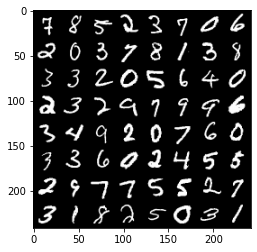

In [ ]:
%pylab inline
import numpy as np

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Как выглядит классификация с RNN в общем виде 

<img src="https://cdn-images-1.medium.com/max/1600/1*vhAfRLlaeOXZ-bruv7Ostg.png" width="400">

In [ ]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super().__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [ ]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

## Обучаем

In [ ]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.7521 | Train Accuracy: 75.89
Epoch:  1 | Loss: 0.3311 | Train Accuracy: 90.44
Epoch:  2 | Loss: 0.2383 | Train Accuracy: 93.14
Epoch:  3 | Loss: 0.1910 | Train Accuracy: 94.66
Epoch:  4 | Loss: 0.1673 | Train Accuracy: 95.36
Epoch:  5 | Loss: 0.1503 | Train Accuracy: 95.88
Epoch:  6 | Loss: 0.1399 | Train Accuracy: 96.07
Epoch:  7 | Loss: 0.1311 | Train Accuracy: 96.30
Epoch:  8 | Loss: 0.1230 | Train Accuracy: 96.60
Epoch:  9 | Loss: 0.1121 | Train Accuracy: 96.91


### Смотрим что на тесте

In [ ]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 97.16


# Сентимент анализ

Домашка — классифицировать отзывы с IMDB на положительный / отрицательный только по тексту.

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment1.png">

Суть такая же, только нужно предобработать тексты — каждому слову сопоставить обучаемый вектор (embedding), который пойдёт дальше в RNN.

In [ ]:
# это уберет боль работы с текстами
!pip install torchtext==0.9.0
!python -m spacy download en

     |████████████████████████████████| 7.1 MB 9.5 MB/s 
     |████████████████████████████████| 735.5 MB 14 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.


     |████████████████████████████████| 12.0 MB 14.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


**Примечание.** Torchtext уже не очень живой проект, а в spacy нет русского.


In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
from torchtext.legacy import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL, root="./data")

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:08<00:00, 9.98MB/s]


In [ ]:
ls -lh data/imdb/aclImdb/

total 1.7M
-rw-r--r-- 1 7297 1000 882K Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 7297 1000 827K Apr 12  2011 imdb.vocab
-rw-r--r-- 1 7297 1000 4.0K Jun 26  2011 README
drwxr-xr-x 4 7297 1000 4.0K Apr 12  2011 test/
drwxr-xr-x 5 7297 1000 4.0K Jun 26  2011 train/


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [ ]:
print(vars(train_data.examples[0]))

{'text': ['It', 'is', 'often', 'only', 'after', 'years', 'pass', 'that', 'we', 'can', 'look', 'back', 'and', 'see', 'those', 'stars', 'who', 'are', 'truly', 'stars', '.', 'As', 'that', 'French', 'film', 'critic', ',', 'whose', 'name', 'escapes', 'me', ',', 'said', ':', '"', 'There', 'is', 'no', 'Garbo', '.', 'There', 'is', 'no', 'Dietrich', '.', 'There', 'is', 'only', 'Louise', 'Brooks', '"', ';', 'and', 'there', 'is', ',', 'thank', 'heavens', '!', 'Louise', 'Brooks', '!', 'This', 'is', 'the', 'third', 'of', 'her', 'European', 'masterpieces', '.', 'But', 'it', 'is', 'also', 'an', 'exceptional', 'film', 'for', 'being', 'one', ',', 'if', 'not', 'the', ',', 'first', 'French', 'talkie', ',', 'for', 'following', 'a', 'script', 'written', 'by', 'famed', 'René', 'Clair', ',', 'for', 'reportedly', 'being', 'finished', '(', 'the', 'direction', ',', 'that', 'is', ')', 'by', 'Georg', 'Pabst', ',', 'and', 'for', 'incorporating', 'the', 'voice', 'of', 'Edith', 'Piaf', 'before', 'she', 'was', 'well'

In [ ]:
# Сделаем еще eval
import random

train_data, valid_data = train_data.split(random_state=random.seed(SEED))

In [ ]:
# Сделаем словарь
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [ ]:
vars(LABEL.vocab)

{'freqs': Counter({'neg': 8810, 'pos': 8690}),
 'itos': ['neg', 'pos'],
 'stoi': defaultdict(None, {'neg': 0, 'pos': 1}),
 'unk_index': None,
 'vectors': None}

Почему 25002, а не 25000?
Потому что $<unk>$ и $<pad>$

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment6.png" width="160">

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 201773), (',', 192526), ('.', 165179), ('a', 109095), ('and', 109013), ('of', 100440), ('to', 93216), ('is', 76366), ('in', 61082), ('I', 53847), ('it', 53489), ('that', 49135), ('"', 44457), ("'s", 43332), ('this', 42034), ('-', 36930), ('/><br', 35349), ('was', 34976), ('as', 30270), ('with', 29764)]


* stoi (string to int)
* itos (int to string)

In [ ]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'a', 'and', 'of', 'to', 'is']


In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# собираем батчи так, чтобы в каждом батче были примеры наиболее похожей длины
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device)

## Делаем модель

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment7.png" width="450">

* В эмбеддер (emb = [torch.nn.Embedding(num_embeddings, embedding_dim)](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding)) запихиваем тензор размерностью **[sentence length, batch size]**
* Эмбеддер возвращает тензор размерностью **[sentence length, batch size, embedding dim]**
* RNN (torch.nn.RNN(embedding_dim, hidden_dim)) возвращает 2 тензора, *output* размера [sentence length, batch size, hidden dim] и *hidden* размера [1, batch size, hidden dim]

In [ ]:
from unicodedata import bidirectional
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim) 


    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.rnn(embedded)
        return nn.Softmax(dim=1)(self.fc(hidden.squeeze(0)))

In [ ]:
model = RNN(len(TEXT.vocab), 128, 200, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.BCEWithLogitsLoss().to(device)
n_epoch = 10

In [ ]:
def accuracy(model, val):
    model.eval()
    score = [(torch.argmax(model(text), 1) == label).float().mean().item() for text, label in val]
    return np.mean(score)

In [ ]:
from tqdm import tqdm

history = []
for e in range(n_epoch):
    model.train()
    for text, label in tqdm(train_iterator):
        
        text = text.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()

        pred = model(text)
        label = F.one_hot(label.to(torch.int64), num_classes=2)
        
        loss = criterion(label.float(), pred)
        loss.backward()

        optimizer.step()

        history.append(loss.item())
    print('Epoch {}/{} | Train accuracy : {} | Val accuracy : {}'.format(e, n_epoch, accuracy(model, train_iterator), accuracy(model, valid_iterator)))

100%|██████████| 274/274 [00:43<00:00,  6.26it/s]


Epoch 0/10 | Train accuracy : 0.5045701903800894 | Val accuracy : 0.4926288845175404


100%|██████████| 274/274 [00:42<00:00,  6.49it/s]


Epoch 1/10 | Train accuracy : 0.5055559177468293 | Val accuracy : 0.4890536726531336


100%|██████████| 274/274 [00:42<00:00,  6.47it/s]


Epoch 2/10 | Train accuracy : 0.5057025547445255 | Val accuracy : 0.4899805794327946


100%|██████████| 274/274 [00:42<00:00,  6.42it/s]


Epoch 3/10 | Train accuracy : 0.5036822211568373 | Val accuracy : 0.4928495762711864


100%|██████████| 274/274 [00:42<00:00,  6.45it/s]


Epoch 4/10 | Train accuracy : 0.5047331204379562 | Val accuracy : 0.4944385593220339


100%|██████████| 274/274 [00:42<00:00,  6.40it/s]


Epoch 5/10 | Train accuracy : 0.5033645072992701 | Val accuracy : 0.5075918079937919


100%|██████████| 274/274 [00:42<00:00,  6.42it/s]


Epoch 6/10 | Train accuracy : 0.499551942204907 | Val accuracy : 0.5074593927395545


100%|██████████| 274/274 [00:42<00:00,  6.48it/s]


Epoch 7/10 | Train accuracy : 0.5074133211678832 | Val accuracy : 0.5067973164683681


100%|██████████| 274/274 [00:42<00:00,  6.43it/s]


Epoch 8/10 | Train accuracy : 0.5014582248064723 | Val accuracy : 0.5066649012141309


100%|██████████| 274/274 [00:42<00:00,  6.46it/s]


Epoch 9/10 | Train accuracy : 0.4954216632529767 | Val accuracy : 0.5070180084745762


In [ ]:
accuracy(model, test_iterator)

0.5076726342710998